In [46]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from src import tokenize
from CustomDatasets.PeptidesWithRetentionTimes import PeptidesWithRetentionTimes
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [47]:
df = pd.read_csv(r"D:\OtherPeptideResultsForTraining\JurkatMultiProtease_AllPeptides.psmtsv", sep='\t')
fullSequence_retentionTimeAvg_df = df[['Full Sequence', 'Scan Retention Time']].where(
    df["Decoy/Contaminant/Target"].str.contains("T") &
      df["Ambiguity Level"].str.contains("1")).dropna()

train_df, test_df = train_test_split(fullSequence_retentionTimeAvg_df, test_size=0.2, random_state=42, shuffle=True)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42, shuffle=True)
#save the test and train dataframes to csv
train_df.to_csv(r"multprotease_train_set.csv", index=False)
test_df.to_csv(r"multiprotease_test_set.csv", index=False)
val_df.to_csv(r"multiprotease_val_set.csv", index=False)


C:\Users\elabo\AppData\Local\Temp\ipykernel_67612\710677232.py:1: DtypeWarning: Columns (11,20,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"D:\OtherPeptideResultsForTraining\JurkatMultiProtease_AllPeptides.psmtsv", sep='\t')


In [48]:
train_df, test_df, val_df 

(                   Full Sequence  Scan Retention Time
 27796                HESWLLHRTLK             76.94551
 99679                  DLMGQPISV            124.85605
 4240    KLEGDSTDLSDQIAELQAQIAELK            173.67520
 106581                  DVLEEGEL            114.63919
 59757            GFQQISFVNSIATSK            127.65213
 ...                          ...                  ...
 115790               EISPTEEVGDF            121.64638
 126273                  DVVSLSIG            104.22567
 108686                GTPWEGGLFK            115.80980
 140493                  YIENQKEY             54.49088
 128668             TQTLSELDLAVPF            166.31394
 
 [116941 rows x 2 columns],
                                             Full Sequence  Scan Retention Time
 52202   ARLKK[Common Biological:Hydroxylation on K]SAD...             77.74031
 43377                                     LRAYLKSKGAEISEE             71.44143
 134706  IVDDTKVKEEPPINHPVGC[Common Fixed:Carbamidometh...            

In [49]:
class TunableAttentionRegression(torch.nn.Module):
    def __init__(self, input_size = 2707, hidden_size = 64,
                output_size = 1, numberOfHeads = 16) -> None:
        super(TunableAttentionRegression, self).__init__()
        self.embedding = torch.nn.Embedding(input_size, 32)
        self.lstm = torch.nn.LSTM(32, hidden_size, batch_first=True)
        self.attention = torch.nn.MultiheadAttention(hidden_size, num_heads=numberOfHeads, batch_first=True) #https://pytorch.org/docs/stable/generated/torch.ao.nn.quantizable.MultiheadAttention.html#multiheadattention
        self.linear1 = torch.nn.Linear(hidden_size*200, output_size, dtype=torch.float32)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x) -> torch.Tensor:
        # print(x.shape)
        x = x.view(x.size(0), x.size(2)*2)
        # print(x.shape)
        embedded = self.embedding(x)
        # print(embedded.shape)
        # embedded = embedded.view(*x.size(), -1) #to make it 3D
        lstm_out, _ = self.lstm(embedded)
        # print(lstm_out.shape)
        # lstm_out = lstm_out.permute(1, 0, 2)  # [seq_len, batch, hidden_size]
        # print(lstm_out.shape)
        query = lstm_out.permute(0, 1, 2)
        key = lstm_out.permute(0, 1, 2)
        value = lstm_out.permute(0, 1, 2)
        # print(query.shape, key.shape, value.shape)
        attention_output, _ = self.attention(query, key, value)
        # print(attention_output.shape)
        attention_output_as_2d = attention_output.reshape(attention_output.size(0), attention_output.size(1)*attention_output.size(2))
        # print(attention_output_as_2d.shape)
        output = self.linear1(attention_output_as_2d)
        # print(output.shape)
        # print(output)
        return output

In [50]:
vocab = tokenize.readVocabulary("C:\\Users\\elabo\\Documents\\GitHub\\RetentionTimeEstimators\\vocab.csv")
training_data = pd.read_csv(r"multprotease_train_set.csv", index_col=None, header=0, usecols=["Full Sequence", "Scan Retention Time"])
testing_data = pd.read_csv(r"multiprotease_test_set.csv", index_col=None, header=0, usecols=["Full Sequence", "Scan Retention Time"])
validation_data = pd.read_csv(r"multiprotease_val_set.csv", index_col=None, header=0, usecols=["Full Sequence", "Scan Retention Time"])

trainingTokens = tokenize.tokenizePreTokens(tokenize.getPreTokens(training_data), vocab, 100, tokenize.TokenFormat.TwoDimensional)
testingTokens = tokenize.tokenizePreTokens(tokenize.getPreTokens(testing_data), vocab, 100, tokenize.TokenFormat.TwoDimensional)
validationTokens = tokenize.tokenizePreTokens(tokenize.getPreTokens(validation_data), vocab, 100, tokenize.TokenFormat.TwoDimensional)

trainingSequences = []
trainingRetentionTimes = []
for i in trainingTokens:
    trainingSequences.append(i[0])
    trainingRetentionTimes.append(i[1])

validationSequences = []
validationRetentionTimes = []
for i in validationTokens:
    validationSequences.append(i[0])
    validationRetentionTimes.append(i[1])

testingSequences = []
testingRetentionTimes = []
for i in testingTokens:
    testingSequences.append(i[0])
    testingRetentionTimes.append(i[1])

trainingDataset = PeptidesWithRetentionTimes(trainingSequences, trainingRetentionTimes)
testingDataset = PeptidesWithRetentionTimes(testingSequences, testingRetentionTimes)
validationDataset = PeptidesWithRetentionTimes(validationSequences, validationRetentionTimes)

c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sequence = str(row[0])
c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preTokens.append((sequence, row[1]))
c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preTokens.

In [51]:
len(trainingDataset), len(testingDataset), len(validationDataset)

(101528, 12665, 12742)

In [52]:
#training data/ validation data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the model
model = TunableAttentionRegression(hidden_size=64, numberOfHeads=8).to(device)
# Create the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Create the loss function
criterion = torch.nn.MSELoss().to(device)

# Create the training data loader
trainingDataLoader = torch.utils.data.DataLoader(trainingDataset,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

validationDataLoader = torch.utils.data.DataLoader(validationDataset,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

testinDataLoader = torch.utils.data.DataLoader(testingDataset,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

c:\Users\elabo\anaconda3\envs\RTPy39\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [53]:
# Train the model
model.train()
epochs = 100
validationLoss = []
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_steps = 0
    for i, data in enumerate(trainingDataLoader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.float()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # print(inputs[:,0].shape, labels.shape)
        outputs = model(inputs.to(device)).to(device).squeeze()
        # print(outputs, labels.shape)
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_steps += 1
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print("[%d, %5d] loss: %.5f" % (epoch + 1, i + 1,
                                            running_loss / epoch_steps))
            running_loss = 0.0

    # Validation loss
    val_loss = 0.0
    val_steps = 0
    total = 0
    correct = 0
    for i, data in enumerate(validationDataLoader):
        with torch.no_grad():
            inputs, labels = data
            labels = labels.float()

            outputs = model(inputs.to(device)).to(device).squeeze()
            total += labels.size(0)
            correct += (outputs.to(device) == labels.to(device)).sum().item()

            loss = criterion(outputs.to(device), labels.to(device))
            val_loss += loss.cpu().numpy()
            val_steps += 1
    validationLoss.append(val_loss)
    scheduler.step(val_loss)
    print(f'Epoch {epoch+1}, Loss: {val_loss:.5f}')

model.eval()
#save the model 
torch.save(model.state_dict(), "mp_lsm_attention_{}.pt".format(epochs))

[1,  2000] loss: 358.42004
Epoch 1, Loss: 81417.35558
[2,  2000] loss: 208.69614
Epoch 2, Loss: 68849.67999
[3,  2000] loss: 197.56329
Epoch 3, Loss: 70102.15033
[4,  2000] loss: 195.06113
Epoch 4, Loss: 69354.09111
[5,  2000] loss: 188.85983
Epoch 5, Loss: 76951.35019
[6,  2000] loss: 184.93131
Epoch 6, Loss: 67857.93909
[7,  2000] loss: 185.20671
Epoch 7, Loss: 68022.76580
[8,  2000] loss: 182.62390
Epoch 8, Loss: 67112.30311
[9,  2000] loss: 177.93377
Epoch 9, Loss: 63480.01248
[10,  2000] loss: 176.31014
Epoch 10, Loss: 63276.34056
[11,  2000] loss: 180.63473
Epoch 11, Loss: 63864.72348
[12,  2000] loss: 180.39890
Epoch 12, Loss: 67703.97326
[13,  2000] loss: 179.68118
Epoch 13, Loss: 67109.14566
[14,  2000] loss: 274.14071
Epoch 14, Loss: 70718.50851
[15,  2000] loss: 174.19789
Epoch 15, Loss: 61826.91685
[16,  2000] loss: 164.14303
Epoch 16, Loss: 62692.66572
[17,  2000] loss: 159.85002
Epoch 17, Loss: 60702.20025
[18,  2000] loss: 158.00515
Epoch 18, Loss: 64563.14745
[19,  2000

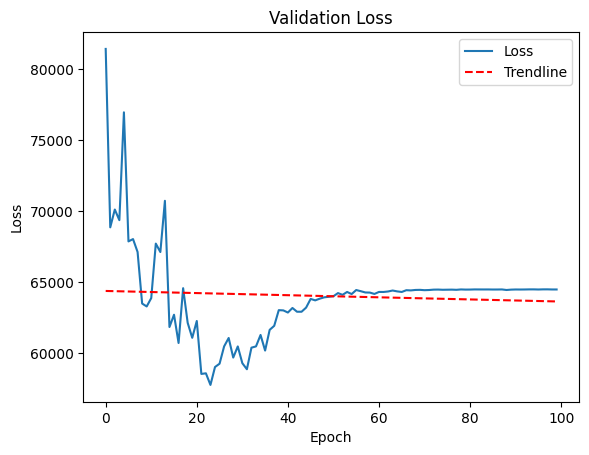

In [54]:
#visualize the loss
plt.plot(validationLoss)
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#trendline
z = np.polyfit(range(0, epochs), validationLoss, 1)
p = np.poly1d(z)
plt.plot(range(0, epochs), p(range(0, epochs)), "r--")
plt.legend(["Loss", "Trendline"])
plt.show()

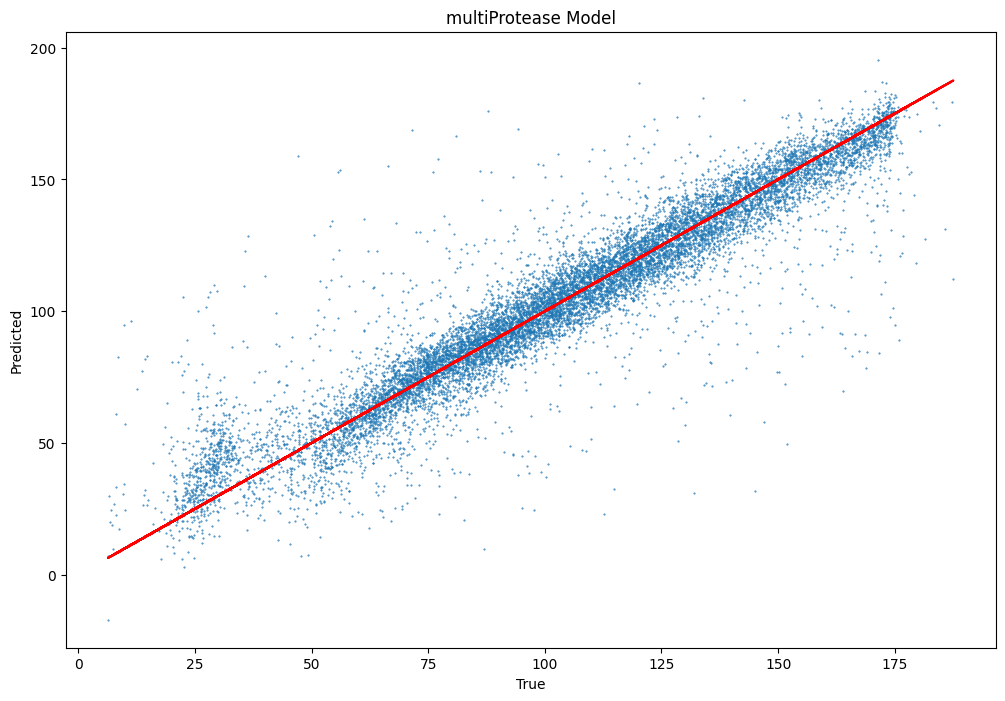

In [66]:
#Test model and get accuracy
testinDataLoader = torch.utils.data.DataLoader(testingDataset,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)
test_loss = 0.0
test_steps = 0
total = 0
correct = 0
# model.load_state_dict(torch.load('secondTry_model_hs_32_epoch_5.pt'))
model.eval()
preds = []

# Test model and calculate accuracy
for i, data in enumerate(testinDataLoader):
    with torch.no_grad():
        inputs, labels = data

        outputs = model(inputs.to(device)).to(device)
        predicted = outputs
        preds.append((labels, predicted))

allPredictions = []
allLabels = []
for label, pred in preds:
    allPredictions.append(pred)
    allLabels.append(label)

flatPreds = torch.stack(allPredictions).tolist()
flatLabels = torch.stack(allLabels).tolist()

# Plot the results
#title
plt.title("multiProtease Model")
#scatter plot
plt.scatter(flatLabels, flatPreds, s=0.2)
plt.plot(flatLabels, flatLabels, color='red')
#labels
plt.xlabel("True")
plt.ylabel("Predicted")
#increase plot size 
plt.gcf().set_size_inches(12, 8)
#show plot
plt.show()